In [1]:

import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [141]:
def display_ptandextended_sources(eclipse, band):
    # really only meant to be used for visualizing while avoiding a whole pipeline run 
    grouped_point_sources, extended_sources = find_sources(eclipse, band)
    
    plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')
    #plt.imshow(centile_clip(filtered))
    cmap = make_random_cmap(ncolors=5000,seed=23)

    for i, group in enumerate(grouped_point_sources.group_by('group_id').groups):
        for i2, point in enumerate(group):
            xypos = np.transpose([point['x_0'], point['y_0']])
            ap = CircularAperture(xypos, r= (point['npix']/3.14)**.5) # using area of kernel to get radius, not same as fwhm
            #ap.plot(color=cmap.colors[point['npix']], lw=(point['sharpness']*2))
            ap.plot(color=cmap.colors[point['npix']], lw=.75)
            #ap.plot(color="red", lw=abs(point['sharpness']*2)+.25)

        
    # convex hull around extended sources
    #for hull in enumerate(extended_sources): 
    #    plt.plot(list(zip(*hull[1]))[0],list(zip(*hull[1]))[1],'w-',lw=1.2)
    
    plt.show()

def find_sources(eclipse, band):

    # temporary work arounds until part of real pipeline:
    # calculating exp time from exp time csv
    exptime = calc_exp_time(eclipse, band)

    print(f"The exposure time is: {exptime}")

    cnt_image = get_image_file(eclipse, band)

    # TODO: don't hardcode this, do we need this?
    #  _ exptime < 300:
    #     print("Skipping low exposure time visit.")
    #     Path(datapath, "LowExpt").touch()
    #     return "Skipping low exposure time visit."

    # 3 point source runs of DAOStarFinder
    small_point_sources = smallStarFinder(cnt_image, exptime)
    med_point_sources = mediumStarFinder(cnt_image, exptime)
    big_point_sources = bigStarFinder(cnt_image, exptime)
    bigger_point_sources = evenBiggerStarFinder(cnt_image, exptime)
    """
    coregistered_points = 
    # below and fun references are mostly michael's code from killscreen 
    mis_raw, mis_rice = check_coregistration(sources_raw, sources_rice)
    sources = sources_raw.loc[~mis_raw].copy()
    summary["n_raw"] = len(sources_raw)
    summary["n_rice"] = len(sources_rice)
    summary["n_mismatch_raw"] = len(np.nonzero(mis_raw)[0])
    summary["n_mismatch_rice"] = len(np.nonzero(mis_rice)[0])
    summary["n_match"] = len(sources)
    sources["match"] = "both"
    mis_raw_sources = sources_raw.loc[mis_raw].copy()
    mis_raw_sources["match"] = "raw"
    mis_rice_sources = sources_rice.loc[mis_rice].copy()
    mis_rice_sources["match"] = "rice"
    all_sources = pd.concat((sources, mis_raw_sources, mis_rice_sources))
    # add FWHM kernel size info to each row of sources table so that we know which star finder 
    # run found which source / to plot them accurately 
    """
    # combine small and big point sources
    combined_point_sources = pd.concat([small_point_sources, med_point_sources, big_point_sources,bigger_point_sources])

    # DBSCANGroup for collecting point sources into groups
    grouped_point_sources, extended_sources = extendedSourceFinder(combined_point_sources)

    try:
        print(f"Located {len(grouped_point_sources)} point sources and {len(extended_sources)} extended sources.")
    except TypeError:
        print(f"{eclipse} {band} contains no sources.")
        return None, None

    return grouped_point_sources, extended_sources

def check_coregistration(ref, comp, threshold=1):
    c_cols = ['xcentroid', 'ycentroid']
    ref_xy = ref[c_cols].to_numpy()
    comp_xy = comp[c_cols].to_numpy()
    ref_offsets = coregister_sources(ref_xy, comp_xy)
    comp_offsets = coregister_sources(comp_xy, ref_xy)
    return (
        ref_offsets > threshold, comp_offsets > threshold
    )

def coregister_sources(xy0, xy1):
    matches = []
    for source_ix in range(xy0.shape[0]):
        vec = xy0[source_ix]
        vec = np.expand_dims(vec, 1).T
        offsets = np.linalg.norm(xy1 - vec, axis=1)
        matches.append(offsets.argmin())
    sort_xy1 = xy1[matches]
    return np.linalg.norm(sort_xy1 - xy0, axis=1)

def smallStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=6, sigma_radius=1.5, threshold=0.004, ratio=1, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def mediumStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=5, sigma_radius=1.5, threshold=0.01, ratio=.75, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def bigStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=5, sigma_radius=1.5, threshold=0.01, ratio=1, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def evenBiggerStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=5, sigma_radius=2, threshold=0.01, ratio=1, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def extendedSourceFinder(positions):
    """uses combined pt source list to identify clumped groups
    of stars as extended sources"""
    from astropy.table import QTable, Table, Column
    from photutils.psf.groupstars import DBSCANGroup

    eps = 40 # dist value for grouping, very important

    starlist = Table()
    starlist['x_0'] = positions["xcentroid"]
    starlist['y_0'] = positions["ycentroid"]
    starlist['sharpness'] = positions["sharpness"]    
    starlist['roundness1'] = positions["roundness1"]
    starlist['roundness2'] = positions["roundness2"]
    starlist['npix'] = positions["npix"]
    starlist['peak'] = positions["peak"]
    starlist['flux'] = positions["flux"]
    
    dbscan_group = DBSCANGroup(crit_separation=eps)
    source_table_grouped = dbscan_group(starlist)
    
    dbsc_groups = source_table_grouped.group_by('group_id')
    # characterize morphology (fit ellipse, convex hull) of each group above a
    # certain cutoff in size
    extended_source_table = extendedSourceMorphology(dbsc_groups)

    return source_table_grouped, extended_source_table

def extendedSourceMorphology(dbsc_groups):
    """uses convex hull on collection of pts id'd as in the same group to show shape of extended source"""
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    extended_source_table = []
    for i, group in enumerate(dbsc_groups.groups):
        if len(group) > 10:
            xypos = np.transpose([group['x_0'], group['y_0']])
            hull = ConvexHull(xypos)
            # might not be the best way to do this, but want # of points in the complex hull
            # so making a list with tuples of the (# of points, [the hull simplices pairs])
            #extended_source_table.append(hull.simplices)
            extended_source_table.append(list(zip(xypos[hull.vertices,0], xypos[hull.vertices,1])))
    return extended_source_table

def calc_exp_time(eclipse, band):
    """sums frame exposure times in exp time csv output by pipeline """
    from os.path import exists
    if band == "FUV":
        b = "fd"
    else:
        b = "nd"
    if exists(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv"):
        exp_time = pd.read_csv(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv")
        tot_exp_time = sum(exp_time["expt"])
    return tot_exp_time

def get_image_file(eclipse, band):
    import fitsio
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/exploration_notebooks/test_data/miniCat', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    # masking cnt image
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

# clipping 
def centile_clip(image, centiles=(0, 100)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

def see_convolved(pic,k_size): 
    from astropy.convolution import convolve
    from photutils.segmentation import (detect_sources,
                                    make_2dgaussian_kernel)
    
    kernel = make_2dgaussian_kernel(3.0, size=3)  # FWHM = 3.
    convolved_data = convolve(pic, kernel)
    return convolved_data

The exposure time is: 1057.4525925575329
Located 20487 point sources and 1 extended sources.


<IPython.core.display.Javascript object>


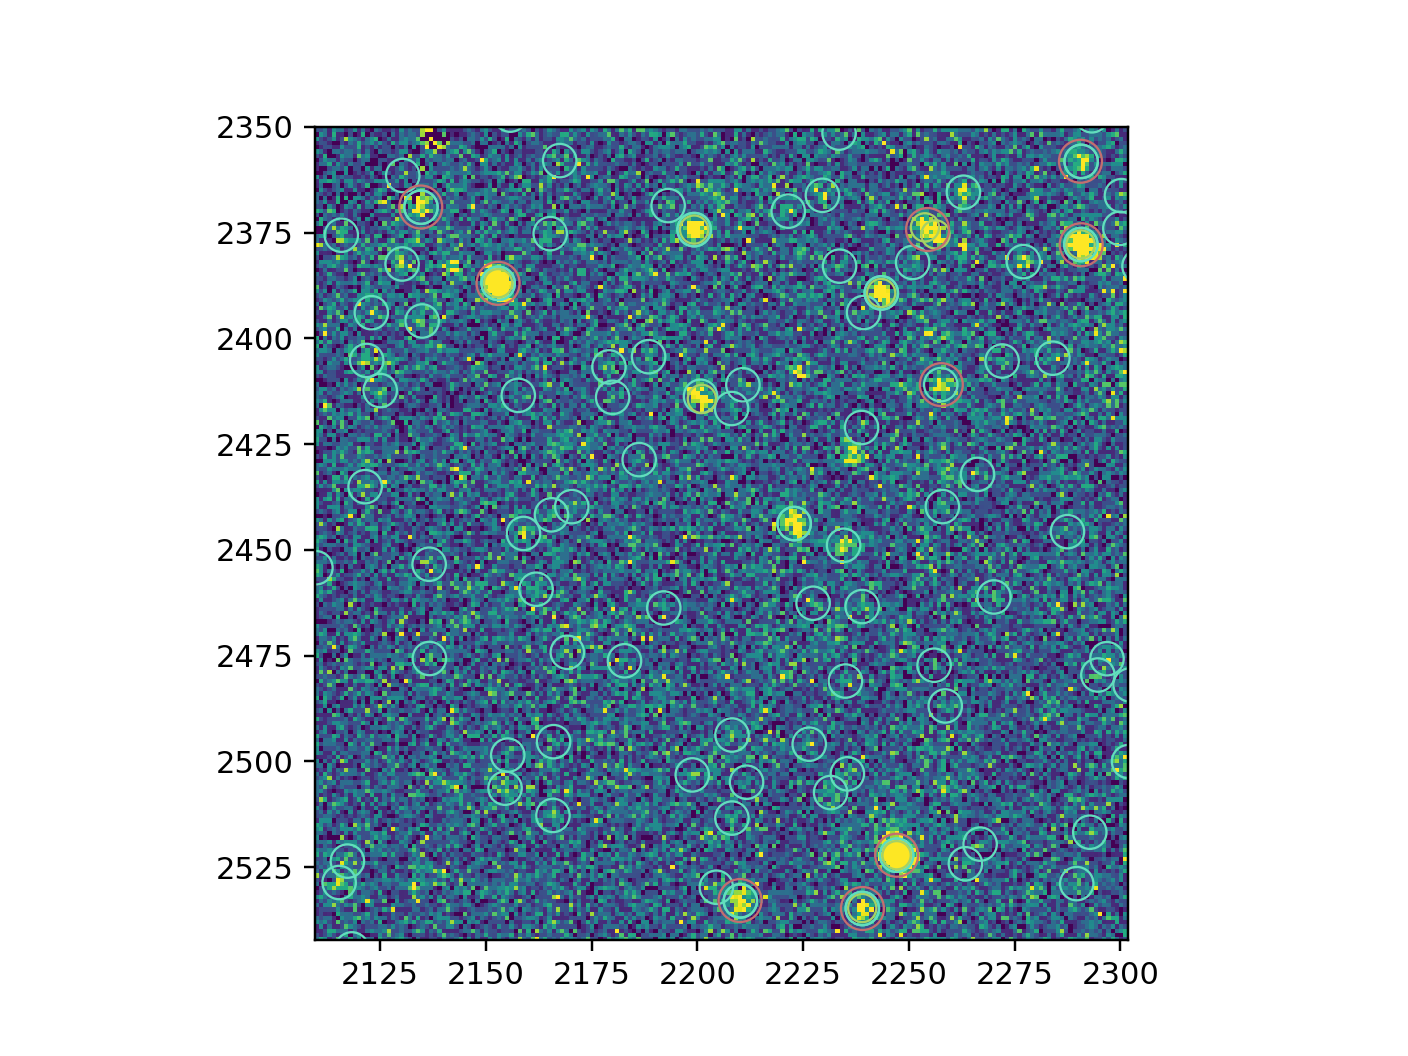

In [143]:
%matplotlib notebook

display_ptandextended_sources("03578","NUV")

grouped_point_sources

In [136]:
pts, extended = find_sources("23403","NUV")
pts = pts.to_pandas()

The exposure time is: 1004.3550357868113
Located 35589 point sources and 1 extended sources.


<IPython.core.display.Javascript object>


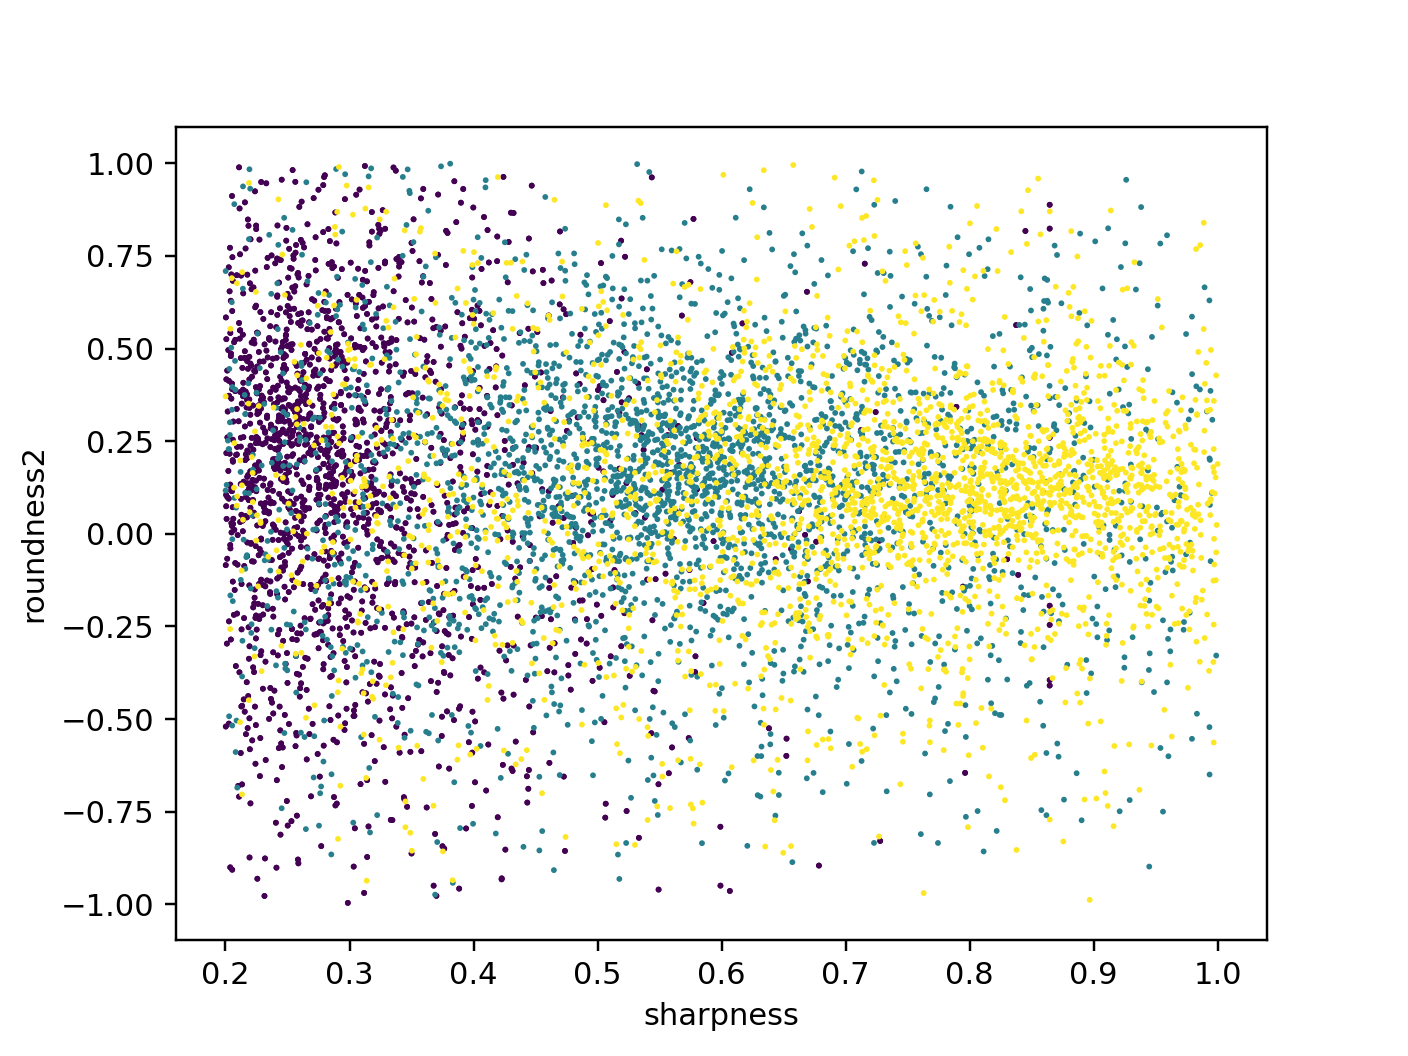

Text(0, 0.5, 'roundness2')

In [108]:
plt.scatter(pts["sharpness"],pts["roundness1"],c=pts["npix"],s=0.8)
plt.xlabel("sharpness")
plt.ylabel("roundness2")

<IPython.core.display.Javascript object>


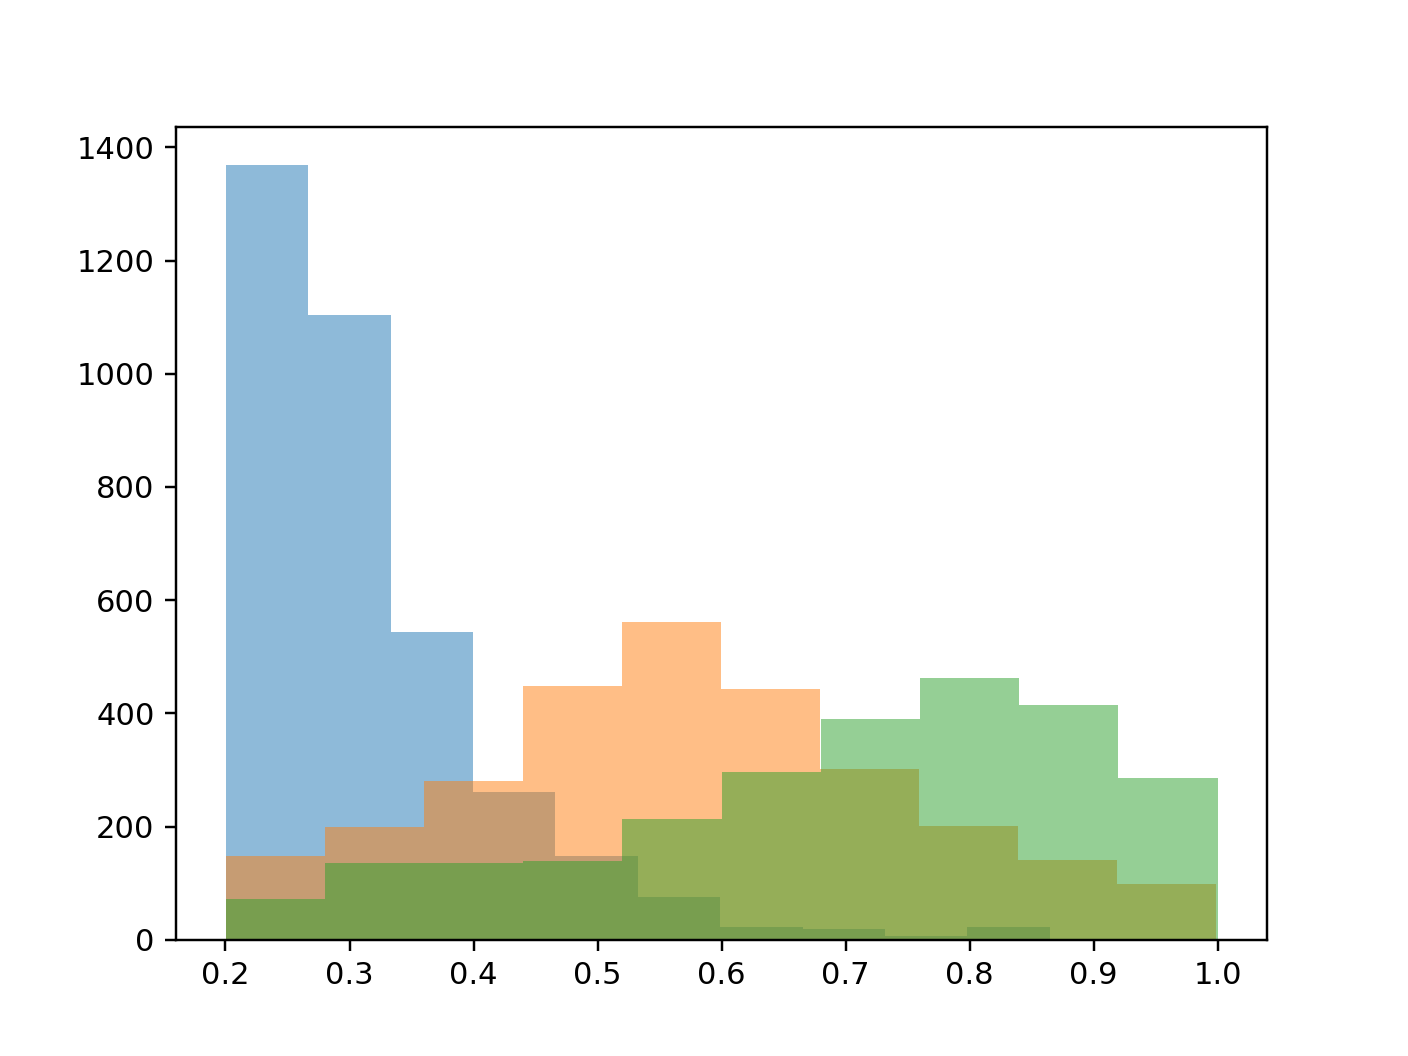

In [120]:
for i, group in enumerate(pts.groupby("npix")):
    #print(group[1]['npix'][0])
    plt.hist(group[1]["sharpness"],alpha=0.5)
plt.show()